In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('/content/names.txt', 'r').read().splitlines()

In [3]:
# build the vocab of chars and mappings to/from intergers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the data set
block_size = 8 # context length: how many chars do we take to predict the next one
def build_dataset(words):
   X, Y = [], []

   for w in words:
    context = [0] * block_size
    for ch in w + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx] # crop and append

   X=torch.tensor(X)
   Y=torch.tensor(Y)
   print(X.shape, Y.shape)
   return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[idx.item()] for idx in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [ ]:
'''
following is what happens in the linear layer
torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)

Goal:
The goal is to modify the linear and flatten layers such that,
the flatten layer does not completely flatten the layer (4, 80), rather creates a (4, 4, 20) vector
and then the linear layer should expect a (4, 4, 20) vector as an input

-- find the reason for doing the above step
-> is it for easier/faster calculcation
-> or does it give better result
'''

In [44]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # kaiming init
    self.bias = torch.randn(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

#------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a runnign 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim = True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

#------------------------------------------------------------------------------------------
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

#------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IDX):
    self.out = self.weight[IDX]
    return self.out

  def parameters(self):
    return [self.weight]

#------------------------------------------------------------------------------------------
'''
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []
'''
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) #  x = x.view(B, -1, C*n)
    if x.shape[1] == 1: # spurious dimention
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

#------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
'''
Layer	                      Operation Description	                                            Output Shape

Embedding(vocab_size, C)	  Each token (int) → C-dimensional vector	                          (4, 8, 10)

FlattenConsecutive	        Group every 2 consecutive tokens → concatenate their embeddings	  (4, 4, 20)

Linear(20, 200)	            Fully connected layer applied to each of the 4 token-pairs	      (4, 4, 200)

BatchNorm1d(200)	          Normalize across batch for each of the 200 features	              (4, 4, 200)

Tanh()	                    Non-linear activation	                                            (4, 4, 200)

FlattenConsecutive	        Group every 2 of the 4 token-pairs → concatenate again	          (4, 2, 400)

Linear(400, 200)	          Another fully connected layer	                                    (4, 2, 200)

BatchNorm1d(200)	          Normalize again	                                                  (4, 2, 200)

Tanh()	                    Activation	                                                      (4, 2, 200)

FlattenConsecutive	        Final grouping → flatten to one vector per example	              (4, 400)

Linear(400, 200)	          Final hidden layer	                                              (4, 200)

BatchNorm1d(200)	          Normalize	                                                        (4, 200)

Tanh()	                    Activation	                                                      (4, 200)

Linear(200, vocab_size)	    Output logits for each character in vocab (27 classes)	          (4, 27)
'''

In [45]:
torch.manual_seed(42);

In [46]:
# MLP
n_embd = 24 # Dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

'''
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = [p for layer in layers for p in layer.parameters()]
'''

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # make last layer less confident
parameters = model.parameters()

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [34]:
idx = torch.randint(0, Xtr.shape[0], (32,)) # let's  look at a batch of just 4 examples
Xb, Yb = Xtr[idx], Ytr[idx]
logits = model(Xb)
print(Xb.shape)
#Xb

torch.Size([32, 8])


In [42]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [37]:
'''
We initially had a small bug in the batch norm layer
If you look at the code, we calculate the mean and variance accross the 0th dimention
It was correct until we did not use the Flatten Consecutive, as with Flatten the input x was supposed to be 2 dim
Now with Flatten Consecutive, x (input for batch norm) is 3 dim, so we will have to calculate mean and var accross dim 0 and 1
So basically what we are doing is keep the stats (mean, var) individually for all the 4 (in our eg. case) independently
Instead what we want to do is to keep the stats for these 4 positions combined (treat is as a batch dim)
So we don't to calculate for 32 numbers, rather we want to calculate over 32*4 numbers for every single one of the 68 channels

The reason of not getting an error is broadcasting, but that does not mean it isn't a bug

'''
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
print(model.layers[3].running_mean.shape)
emean.shape, evar.shape, ehat.shape

torch.Size([1, 4, 68])


(torch.Size([1, 4, 68]), torch.Size([1, 4, 68]), torch.Size([32, 4, 68]))

In [47]:
# Optimization
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

  # mini-batch construct
  idx = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

  # forward pass
  '''
  No longer required
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concat the vectors
  '''
  '''
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  '''
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<150000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
  loss_i.append(loss.log10().item())

  #break

      0/ 200000:  4.6212
  10000/ 200000:  2.1471
  20000/ 200000:  1.5086
  30000/ 200000:  2.1991
  40000/ 200000:  2.0678
  50000/ 200000:  1.8112
  60000/ 200000:  2.3209
  70000/ 200000:  1.9109
  80000/ 200000:  1.5973
  90000/ 200000:  1.8337
 100000/ 200000:  2.0202
 110000/ 200000:  2.2274
 120000/ 200000:  1.8608
 130000/ 200000:  2.1748
 140000/ 200000:  1.7984
 150000/ 200000:  2.0833
 160000/ 200000:  2.1611
 170000/ 200000:  1.7996
 180000/ 200000:  1.7231
 190000/ 200000:  1.8489


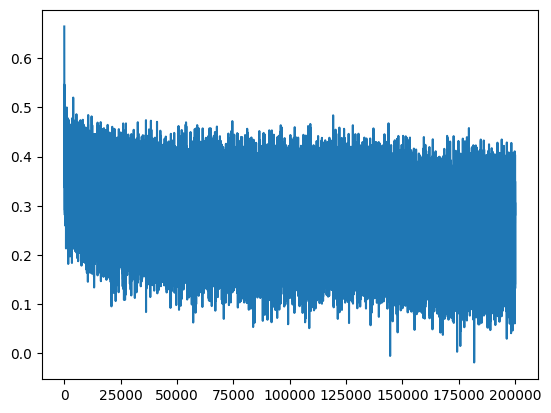

In [48]:
plt.plot(loss_i)

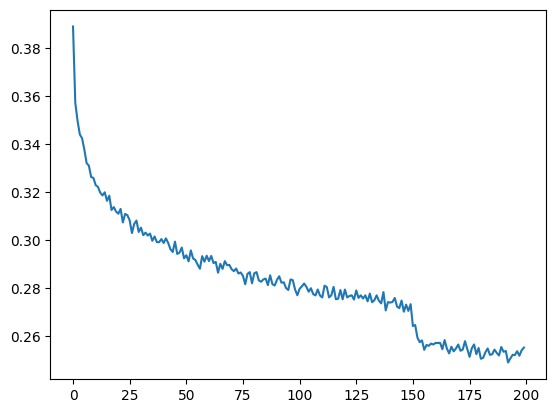

In [49]:
plt.plot(torch.tensor(loss_i).view(200, 1000).mean(1))

In [50]:
# put layers into eval mode (neede for batchnorm especially)
'''
for layer in layers:
  layer.training = False
'''
for layer in model.layers:
  layer.training = False

In [51]:
# evaluate the loss
@ torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  '''
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  '''
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7673869132995605
val 1.9882043600082397


In [56]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      '''
      emb = C[torch.tensor([context])] # (1, block_size, d)
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
        x = layer(x)
      logits = x
      '''
      logits = model(torch.tensor([context]))
      # sample
      probs = F.softmax(logits, dim=1)
      idx = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [idx]
      out.append(idx)
      if idx == 0:
        break

    print(''.join(itos[i] for i in out))

anjalyce.
meliana.
herppere.
mackley.
cra.
orian.
ariyano.
hemere.
simun.
alexi.
taklyn.
alyse.
haydan.
macaona.
esteal.
avneya.
mariyah.
dinai.
laislyn.
emenna.
